In [0]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
#Set seed to make random numbers more predictable for reproducability
np.random.seed(0)

In [0]:
#Artificial Dataset 1
points_ad1 = np.random.uniform(low=-1.0, high=1.0, size=(400,2)) 
classes_ad1 = []
for point in points_ad1:
  if point[0] >= 0.7:
    classes_ad1.append(1)
  elif point[0] >= 0.3 and point[1] >= (-0.2-point[0]):
    classes_ad1.append(1)
  else: 
    classes_ad1.append(0)
classes_ad1 = np.array(classes_ad1)
num_clusters_ad1 = 2

In [0]:
#Iris Dataset
iris = datasets.load_iris()
points_iris = iris.data
classes_iris = iris.target
num_clusters_iris = 3
del iris

In [0]:
#DEBUG: p1 and p2 should be list
def euclidian_distance(p1,p2):
  dist = 0
  for i in range(len(p1)):
    dist += (p1[i] - p2[i])**2
  return np.sqrt(dist)

In [0]:
def assign_to_cluster(points,centroids):
  class_assgn = []
  num_clusters= len(centroids)
  for point in points:
    distances = []
    for i in range(num_clusters):
      distances.append(euclidian_distance(centroids[i],point))
    class_assgn.append(np.argmin(distances))
  return np.array(class_assgn)

In [0]:
def recalculate_centroids(classes,points,num_clusters,centroid_old):
  centroids = []
  for i in range(num_clusters):
    indices = np.where(np.array(classes) == i)[0]
    sum_ = np.zeros(len(points[0]))
    if len(indices) > 0:
      for index in indices:
        sum_ = sum_ + points[index]
      sum_ = sum_ / len(indices)
      centroids.append(sum_)
    else:
      centroids.append(centroid_old[i])
  return np.array(centroids)

In [0]:
def k_means_clustering(points,num_clusters,max_iter=1000):
  picks = np.random.randint(0,len(points)-1,size=num_clusters)
  centroids = []
  for pick in picks:
    centroids.append(points[pick])
  centroids = np.array(centroids)
  classes = 0
  for i in range(max_iter):
    classes = assign_to_cluster(points,centroids)
    centroids = recalculate_centroids(classes,points,num_clusters,centroids)
  return classes, centroids

In [0]:
def quantization_error(points,classes,num_clusters,centroids):
  q_e = 0.0
  for i in range(num_clusters):
    indices = np.where(classes == i)[0]
    num_points = len(indices)
    for index in indices:
      q_e += euclidian_distance(points[index],centroids[i]) / num_points
  return q_e/num_clusters

In [0]:
#the distance between data vectors within a cluster
def intracluster_distance(points,classes,num_clusters):
  intra_d = 0.0
  for i in range(num_clusters):
    indices = np.where(np.array(classes) == i)[0]
    num_points = len(indices)
    for j in range(0,num_points):
      for k in range(j+1,num_points):
        intra_d += euclidian_distance(points[indices[j]],points[indices[k]])
  return intra_d

In [0]:
# the distance between the centroids of the clusters
def intercluster_distance(centroids):
  inter_d = 0.0
  for i in range(0,len(centroids)):
    for j in range(i+1,len(centroids)):
      inter_d += euclidian_distance(centroids[i],centroids[j])
  return inter_d

In [0]:
def PSO(points,num_clusters,num_particles=10,funcs=1000,w=0.72,alpha_1 = 1.49,alpha_2 = 1.49):
  #For each iteration, num_particles function evaluations are done
  dim = len(points[0])
  max_iter = funcs//num_particles
  #Initialize particles by randomly picking centroids
  particles = []
  #Velocities initialized to 0
  v = np.zeros((num_particles,num_clusters,dim))
  for i in range(num_particles):
    picks = np.random.randint(0,len(points)-1,size=num_clusters)
    centroids = []
    for pick in picks:
      centroids.append(points[pick])
    centroids = np.array(centroids)
    particles.append(centroids)
  particles = np.array(particles)
  #Create local and global best
  global_best = 0
  global_best_centroid = np.zeros((num_clusters,dim))
  local_best = np.zeros(num_particles)
  local_best_centroid = np.zeros((num_particles,num_clusters,dim))
  #Iterate
  for i in range(max_iter):
    #Compute fitness of each particle
    fitness = []
    for j in range(num_particles):
      centroids = particles[j]
      classes = assign_to_cluster(points,centroids)
      this_fitness = quantization_error(points,classes,num_clusters,centroids)
      fitness.append(this_fitness)
      #Update local best
      #Initialize if first iteration
      #the less error, the better 
      if (this_fitness < local_best[j]) or (i == 0):
        local_best[j] = this_fitness
        local_best_centroid[j] = particles[j]
    fitness = np.array(fitness)
    #Update global best
    #Initialize if first iteration
    if (np.min(fitness) < global_best) or (i == 0):
      global_best = np.min(fitness)
      global_best_centroid = particles[np.argmin(fitness)] 
    #Update particles
    for j in range(num_particles):
      #Pick r's
      r1 = np.random.uniform(low=0, high=1, size=dim)
      r2 = np.random.uniform(low=0, high=1, size=dim)
      #Update velocity
      v[j] = w*v[j] + alpha_1 * np.multiply(r1,local_best_centroid[j]-particles[j]) + alpha_2 * np.multiply(r2,global_best_centroid-particles[j])
      #Update particle
      particles[j] = particles[j] + v[j]
  return assign_to_cluster(points,global_best_centroid),global_best_centroid,particles  

In [30]:
#Average over executions
qe_pso_ad1 = []
qe_kmc_ad1 = []
qe_pso_iris = []
qe_kmc_iris = []

inter_pso_ad1 = []
inter_kmc_ad1 = []
inter_pso_iris = []
inter_kmc_iris = []

intra_pso_ad1 = []
intra_kmc_ad1 = []
intra_pso_iris = []
intra_kmc_iris = []

for i in range(30):
  print("Run: ",i)
  classes_PSO_ad1, centroids_PSO_ad1, particles_ad1 = PSO(points_ad1,2)  
  classes_PSO_iris, centroids_PSO_iris, particles_iris = PSO(points_iris,3)  
  classes_kmc_ad1,centroids_kmc_ad1 = k_means_clustering(points_ad1,2)
  classes_kmc_iris,centroids_kmc_iris = k_means_clustering(points_iris,3)
  qe_pso_ad1.append(quantization_error(points_ad1,classes_PSO_ad1,2,centroids_PSO_ad1))
  qe_kmc_ad1.append(quantization_error(points_ad1,classes_kmc_ad1,2,centroids_kmc_ad1))
  qe_pso_iris.append(quantization_error(points_iris,classes_PSO_iris,3,centroids_PSO_iris))
  qe_kmc_iris.append(quantization_error(points_iris,classes_kmc_iris,3,centroids_kmc_iris))
  inter_pso_ad1.append(intercluster_distance(centroids_PSO_ad1))
  inter_kmc_ad1.append(intercluster_distance(centroids_kmc_ad1))
  inter_pso_iris.append(intercluster_distance(centroids_PSO_iris))
  inter_kmc_iris.append(intercluster_distance(centroids_kmc_iris))
  intra_pso_ad1.append(intracluster_distance(points_ad1,classes_PSO_ad1,2))
  intra_kmc_ad1.append(intracluster_distance(points_ad1,classes_kmc_ad1,2))
  intra_pso_iris.append(intracluster_distance(points_iris,classes_PSO_iris,3))
  intra_kmc_iris.append(intracluster_distance(points_iris,classes_kmc_iris,3))
print("QE PSO AD1: ", np.mean(qe_pso_ad1), " +/- ", np.std(qe_pso_ad1))
print("QE KMC AD1: ",np.mean(qe_kmc_ad1), " +/- ", np.std(qe_kmc_ad1))
print("QE PSO Iris: ",np.mean(qe_pso_iris), " +/- ", np.std(qe_pso_iris))
print("QE KMC Iris: ",np.mean(qe_kmc_iris), " +/- ", np.std(qe_kmc_iris))

print("Intercluster Distance PSO AD1: ", np.mean(inter_pso_ad1), " +/- ", np.std(inter_pso_ad1))
print("Intercluster Distance KMC AD1: ",np.mean(inter_kmc_ad1), " +/- ", np.std(inter_kmc_ad1))
print("Intercluster Distance PSO Iris: ",np.mean(inter_pso_iris), " +/- ", np.std(inter_pso_iris))
print("Intercluster Distance KMC Iris: ",np.mean(inter_kmc_iris), " +/- ", np.std(inter_kmc_iris))

print("Intracluster Distance PSO AD1: ", np.mean(intra_pso_ad1), " +/- ", np.std(intra_pso_ad1))
print("Intracluster Distance KMC AD1: ",np.mean(intra_kmc_ad1), " +/- ", np.std(intra_kmc_ad1))
print("Intracluster Distance PSO Iris: ",np.mean(intra_pso_iris), " +/- ", np.std(intra_pso_iris))
print("Intracluster Distance KMC Iris: ",np.mean(intra_kmc_iris), " +/- ", np.std(intra_kmc_iris))

Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Run:  5
Run:  6
Run:  7
Run:  8
Run:  9
Run:  10
Run:  11
Run:  12
Run:  13
Run:  14
Run:  15
Run:  16
Run:  17
Run:  18
Run:  19
Run:  20
Run:  21
Run:  22
Run:  23
Run:  24
Run:  25
Run:  26
Run:  27
Run:  28
Run:  29
QE PSO AD1:  0.4483423582991428  +/-  0.15772207987321163
QE KMC AD1:  0.5960725595571661  +/-  0.01036686171372382
QE PSO Iris:  0.6340846832697961  +/-  0.203559755249773
QE KMC Iris:  0.6580749536035821  +/-  0.02311621303622731
Intercluster Distance PSO AD1:  4.105225865405148  +/-  2.936023929903835
Intercluster Distance KMC AD1:  1.0246694093459494  +/-  0.031723509233312505
Intercluster Distance PSO Iris:  18.52952750956553  +/-  25.62653927039058
Intercluster Distance KMC Iris:  9.854639600438002  +/-  0.5721513788779096
Intracluster Distance PSO AD1:  79516.2891660462  +/-  14403.746966923758
Intracluster Distance KMC AD1:  32451.247824268816  +/-  475.768146039762
Intracluster Distance PSO Iris:  8809.809220522979  +/-  

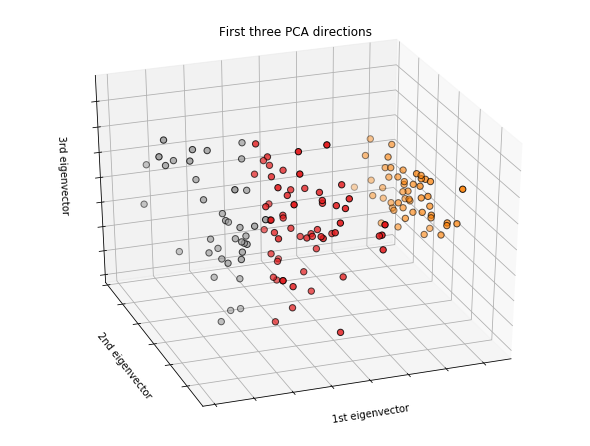

In [37]:
#https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

#Change this to visualize iris
classes = -1

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(points_iris)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=classes,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

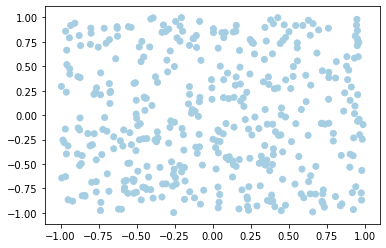

In [0]:
#Change this to visualize AD1
classes = -1

plt.scatter(points_ad1[:,0], points_ad1[:, 1], c=classes, cmap="Paired")

In [0]:
''' Uncomment below if you would like to run the algorithms only
classes_PSO_ad1, centroids_PSO_ad1, particles_ad1 = PSO(points_ad1,2)  
classes_PSO_iris, centroids_PSO_iris, particles_iris = PSO(points_iris,3)  
classes_kmc_ad1,centroids_kmc_ad1 = k_means_clustering(points_ad1,2)
classes_kmc_iris,centroids_kmc_iris = k_means_clustering(points_iris,3)
print("QE PSO AD1: ",quantization_error(points_ad1,classes_PSO_ad1,2,centroids_PSO_ad1))
print("QE KMC AD1: ",quantization_error(points_ad1,classes_kmc_ad1,2,centroids_kmc_ad1))
print("QE PSO Iris: ",quantization_error(points_iris,classes_PSO_iris,3,centroids_PSO_iris))
print("QE KMC Iris: ",quantization_error(points_iris,classes_kmc_iris,3,centroids_kmc_iris))
'''

' Uncomment below if you would like to run the algorithms only once\nclasses_PSO_ad1, centroids_PSO_ad1, particles_ad1 = PSO(points_ad1,2)  \nclasses_PSO_iris, centroids_PSO_iris, particles_iris = PSO(points_iris,3)  \nclasses_kmc_ad1,centroids_kmc_ad1 = k_means_clustering(points_ad1,2)\nclasses_kmc_iris,centroids_kmc_iris = k_means_clustering(points_iris,3)\nprint("QE PSO AD1: ",quantization_error(points_ad1,classes_PSO_ad1,2,centroids_PSO_ad1))\nprint("QE KMC AD1: ",quantization_error(points_ad1,classes_kmc_ad1,2,centroids_kmc_ad1))\nprint("QE PSO Iris: ",quantization_error(points_iris,classes_PSO_iris,3,centroids_PSO_iris))\nprint("QE KMC Iris: ",quantization_error(points_iris,classes_kmc_iris,3,centroids_kmc_iris))\n'